In [1]:
import math
import numpy as np
import numpy.random as npr  
from pylab import plt, mpl

In [2]:
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False


## 伯努利分布

### 伯努利分布的随机数

In [3]:
# 同时抛五枚硬币，出现正面朝上的次数 ——实验10次
a = np.random.binomial(5, 0.5, 10)
a

array([1, 3, 2, 3, 1, 3, 3, 4, 2, 2])

### 伯努利分布的概率

In [4]:
# 同时抛掷5枚硬币，则5次同时为正面发生的概率——采样size=100000次
sum(np.random.binomial(5, 0.5, size=100000) == 5)/100000.

0.03058

### 伯努利分布的市场模型

#### 简易市场模型中的博弈

    假设我们的市场并不是一个处于牛市或者熊市大趋势下的市场， 而是具有涨跌随机波动特征的短线交易市场，可以不分昼夜的不停交易，而且还不需要手续费。  
        
    我们的初始资金为1000元，每次用0.01的仓位随即买9个股票，如果一半以上的股票涨了的话则赚一倍投入的钱，否则当一半以上的股票跌了，投入的钱就全部亏损  

In [5]:
def simpmarket(win_rate, play_cnt=1000, stock_num=9, position=0.01, commission=0.01, lever=False):
    '''
    win_rate : 概率
    play_cnt ： 赌局次数
    stock_num : 股票数量
    position ：仓位比例
    commission ： 手续费
    lever ： 加注标志
    '''
    my_money = np.zeros(play_cnt)
    my_money[0] = 1000
    lose_count = 1
    binomial = np.random.binomial(stock_num, win_rate, play_cnt)

    for i in range(1, play_cnt):
        if my_money[i - 1] * position * lose_count <= my_money[i - 1]:  # 资金充足
            once_chip = my_money[i - 1] * position * lose_count
        else:
            break
        if binomial[i] > stock_num // 2:  # 一半以上的股票上涨
            # 三目运算
            # 如果lever == False 结果为真，则不加注，my_money[i] = my_money[i-1] + once_chip
            # 如果lever == False 结果为假，则加注，my_money[i] = my_money[i-1] + once_chip*lose_count
            my_money[i] = my_money[i - 1] + once_chip if lever == False else my_money[i - 1] + once_chip * lose_count
            lose_count = 1
        else:
            my_money[i] = my_money[i - 1] - once_chip if lever == False else my_money[i - 1] - once_chip * lose_count
            lose_count += 1
        my_money[i] -= commission
        if my_money[i] <= 0:
            break
    return my_money

In [6]:
trader = 50

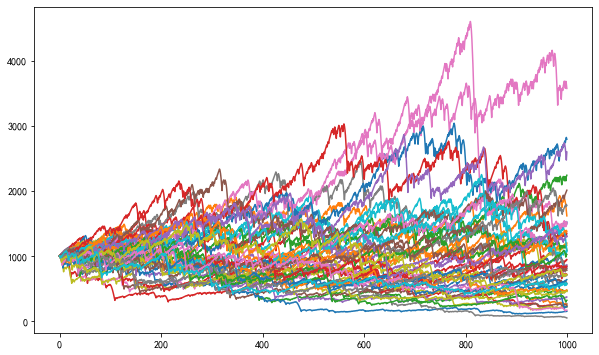

In [7]:
fig = plt.figure(figsize=(10,6))
for _ in np.arange(0,trader):
    my_money = simpmarket(0.5, play_cnt=1000,  stock_num=9, commission = 0)
    plt.plot(np.arange(1000), my_money)

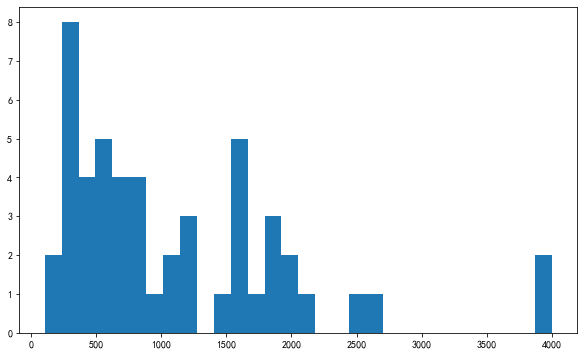

In [8]:
fig = plt.figure(figsize=(10,6))
_ = plt.hist([simpmarket(0.5, play_cnt=1000, stock_num=9, commission = 0)[-1] \
                                                              for _ in np.arange(0, trader)], bins=30)

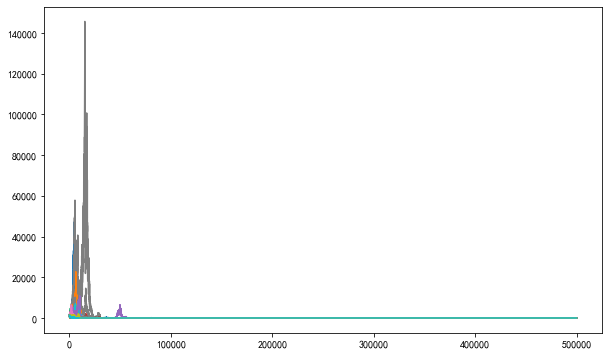

In [9]:
#概率50% 有手续费 参加500000次 
fig = plt.figure(figsize=(10,6))
_ = [plt.plot(np.arange(500000), simpmarket(0.5, play_cnt=500000,  stock_num=9, commission=0)) \
                                                              for _ in np.arange(0,trader)]


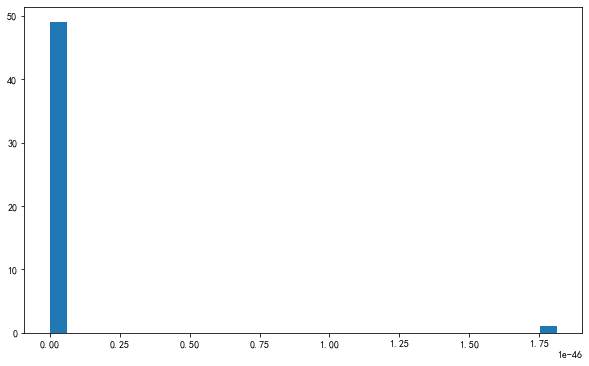

In [10]:
fig = plt.figure(figsize=(10,6))
_ = plt.hist([simpmarket(0.5, play_cnt=500000, stock_num=9, commission = 0)[-1] \
                                                               for _ in np.arange(0, trader)], bins=30)

显然最后肯定**亏损**，我们需要改变策略
在伯努利分布中，无论买了多少次股票，下一次股票涨得概率还是0.5，那么只要运气不是太差总会碰到涨得时候。所以出现一半股票跌就继续买，越跌越买，同时加大每一次下注的仓位，加大的倍数一定超过赔率。

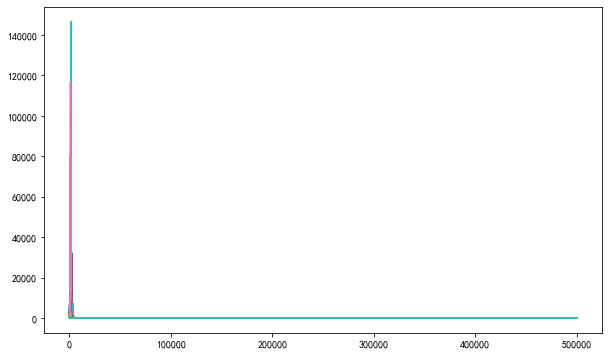

In [11]:
#概率50% 有手续费  加注 参加500000次 
fig = plt.figure(figsize=(10,6))
_ = [plt.plot(np.arange(500000), simpmarket(0.5, play_cnt=500000,  stock_num=9, commission=0, lever=True)) \
                                                              for _ in np.arange(0,trader)]

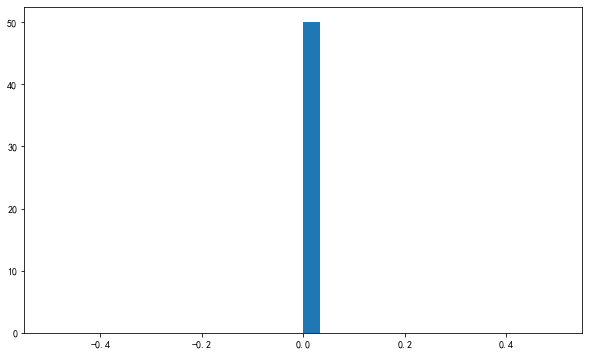

In [12]:
fig = plt.figure(figsize=(10,6))
_ = plt.hist([simpmarket(0.5, play_cnt=500000, stock_num=9, commission = 0, lever=True)[-1] \
                                                               for _ in np.arange(0, trader)], bins=30)

有一说一，不吹不黑，改为加注也不能改变最后血本无归的事实，原书作者在这里将play_cnt改为了1000，其实从1000次中就能看出很多条线其实还是归零了

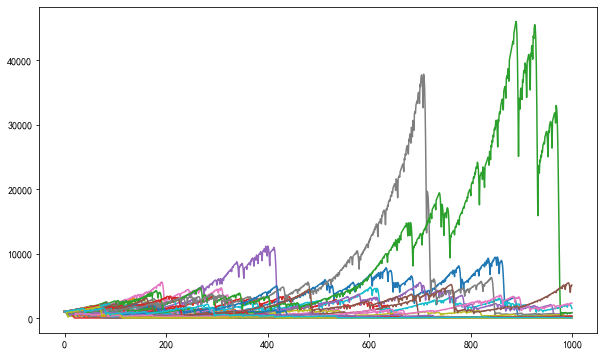

In [13]:
fig = plt.figure(figsize=(10,6))
_ = [plt.plot(np.arange(1000), simpmarket(0.5, play_cnt=1000,  stock_num=9, commission=0, lever=True)) \
                                                              for _ in np.arange(0,trader)]

### 仓位管理在模型中的作用

In [14]:
def positmanage(play_cnt=1000, stock_num=9, commission=0.01, traders=50):
    '''
    简易的市场模型应用仓位管理
    -------------------------
    play_cnt ： 赌局次数
    stock_num ： 股票数量
    commission ： 手续费
    traders ： 交易人数
    '''
    my_money = np.zeros(play_cnt)
    my_money[0] = 1000
    win_rate = np.random.uniform(0.5, 1)  # 生成[0.5,1)之间的浮点数
    binomial = np.random.binomial(stock_num, win_rate, play_cnt)
    for i in range(1, play_cnt):
        once_chip = my_money[i-1] * (win_rate * 1 - (1 - win_rate))/1 # 凯利公式下注
        if binomial[i] > stock_num//2:
            # 三目运算
            # 如果lever == False 结果为真，my_money[i] = my_money[i-1] + once_chip
            # 如果lever == False 结果为假，my_money[i] = my_money[i-1] + once_chip*lose_count
            my_money[i] = my_money[i-1] + once_chip
        else:
            my_money[i] = my_money[i-1] - once_chip
        my_money[i] -= commission
        if my_money[i] <= 0:
            break

    return my_money

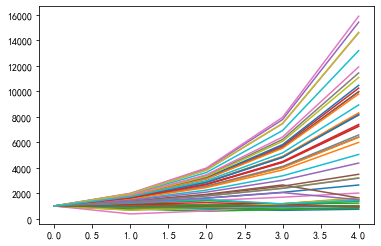

In [15]:
_ = [plt.plot(np.arange(5), positmanage(play_cnt=5,  stock_num=9, commission=0.01)) 
     for _ in np.arange(0,trader)]


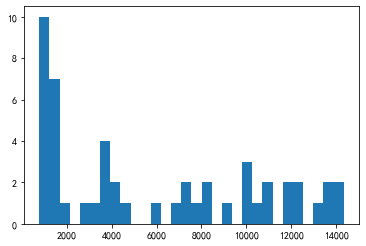

In [16]:
_ = plt.hist([positmanage(play_cnt=5, stock_num=9, commission = 0)[-1] \
            for _ in np.arange(0, trader)], bins=30)

## 正态分布

numpy.random.normal(loc, scale, size)
- loc: 期望值
- scale: **标准差**
- size: 数量

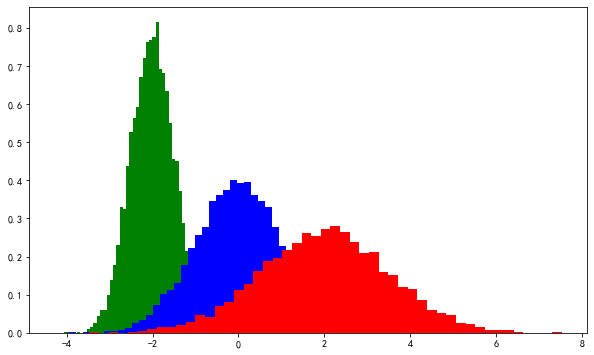

In [17]:
fig = plt.figure(figsize=(10,6))
plt.hist(np.random.normal(loc=-2, scale=0.5, size=10000), bins=50, density=True, color= 'g')
plt.hist(np.random.normal(loc=0, scale=1, size=10000), bins=50, density=True, color= 'b')
plt.hist(np.random.normal(loc=2, scale=1.5, size=10000), bins=50, density=True, color= 'r');

### 生成概率密度函数

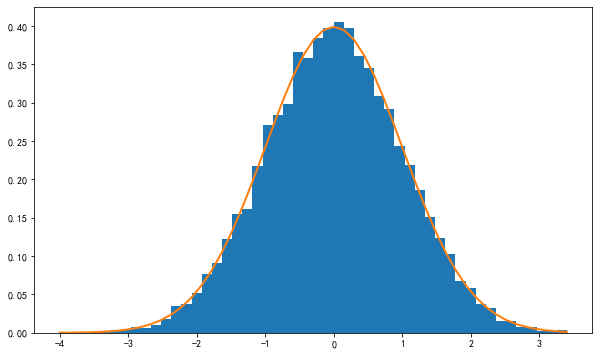

In [18]:
fig = plt.figure(figsize=(10,6))
_, bins, _ = plt.hist(np.random.normal(loc=0, scale=1, size=10000), bins=50, density=True)
plt.plot(bins, 1. / (np.sqrt(2 * np.pi) * 1) * np.exp(-(bins - 0) ** 2 / (2 * 1 ** 2)), 
         label='$\mu$=%.1f, $\sigma^2$=%.1f' % (0, 1), lw=2); #公式计算求得函数值


In [19]:
import scipy.stats as scs

In [20]:
def draw_normal(mu=0, sigma=1, size=10000):
    np.random.seed(0)  # 固定随机乱数，使得你的结果和我的结果一致
    dnormal = np.random.normal(mu, sigma, size=size)
    #dnormal = mu + sigma * np.random.randn(size)#np.random.randn(size)标准正态分布
    plt.hist(dnormal, bins=50, density=True)
    x = np.linspace(plt.axis()[0], plt.axis()[1])
    y = scs.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='$\mu$=%.1f, $\sigma^2$=%.1f' % (mu, sigma))#scipy.stats.norm方式求得函数值

    plt.xlabel('Expectation')
    plt.ylabel('Probability')
    plt.title('histogram of normal distribution:');


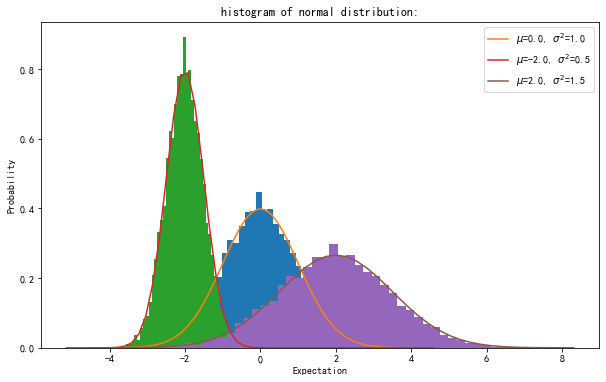

In [21]:
plt.figure(figsize=(10, 6))
draw_normal(0,1,10000)
draw_normal(-2,0.5,10000)
draw_normal(2,1.5,10000)
plt.legend(loc=0, ncol=1)#loc自适应、ncol列的数量

In [22]:
import math

In [23]:
def gd(x, mu=0, sigma=1):
    '''
    根据公式，由自变量x计算因变量的值

    Argument:
        x: array
            输入数据（自变量）
        mu: float
            均值
        sigma: float
            方差
    '''

    left = 1 / (np.sqrt(2 * math.pi) * np.sqrt(sigma))
    right = np.exp(-(x - mu)**2 / (2 * sigma))
    return left * right


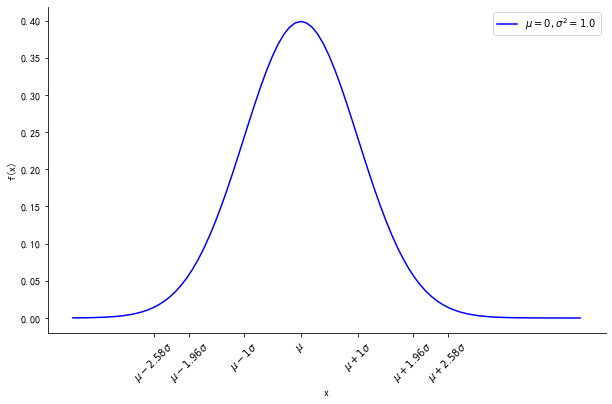

In [24]:
fig = plt.figure(figsize=(10,6))
x = np.arange(-4, 5, 0.1)
#因变量（不同均值或方差）
y_2 = gd(x, 0, 1.0)
plt.plot(x, y_2, color='blue')
#设置坐标系
#plt.xlim(-5.0, 5.0)
#plt.ylim(0, 1)
#设置轴标签
plt.xlabel('x')
plt.ylabel('f(x)')
#x_location = np.arange(-3.0, 4.0, 1) # x轴坐标位置 匹配 3\sigma 2\sigma 1\sigma
x_location = [-2.58, -1.96, -1, 0, 1, 1.96, 2.58] #
x_labels = ['$\mu-2.58\sigma$','$\mu-1.96\sigma$','$\mu-1\sigma$','$\mu$','$\mu+1\sigma$','$\mu+1.96\sigma$','$\mu+2.58\sigma$'] #x轴坐标显示标签
plt.xticks(x_location,x_labels, rotation = 45)

ax = plt.gca()
ax.spines['right'].set_color('none')#隐藏上右边
ax.spines['top'].set_color('none')#隐藏上边
#ax.xaxis.set_ticks_position('bottom')#移动轴
#ax.spines['bottom'].set_position(('data', 0))
#ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data', 0))
plt.legend(labels=['$\mu = 0, \sigma^2=1.0$']);

## 正态分布与随即漫步

### 随机漫步的轨迹

In [25]:
def random_walk(nsteps = 1000):
    
    draws = np.random.randint(0, 2, size=nsteps)
    #print(f'random walk direction is {draws}')# random walk direction is [1 0 1 ... 0 1 0]
    steps = np.where(draws > 0, 1, -1) #将0转换为-1
    walk = steps.cumsum() #累加方式记录轨迹
    return walk

In [26]:
def draw_random_walk():
    fig = plt.figure(figsize=(12,8))
    walk_step = 2000
    walk_path = random_walk(walk_step)
    
    # 统计漫步过程中，终点、前进和后退最大的距离
    start_x = 0
    start_y = 0
    
    end_y = walk_path[-1]
    end_x = walk_step - 1
    
    max_y = walk_path.max()
    max_x = walk_path.argmax()
    
    min_y = walk_path.min()
    min_x = walk_path.argmin()
    
    x = np.linspace(0, 2000, num=2000)
    
    # 绘制出漫步足迹
    plt.plot(x, walk_path, c='b', lw=1, label='walk step')
    
    # 添加标注
    # 起点坐标
    plt.annotate(u'start:(%.0f, %.0f)' % (start_x, start_y),
                xy = (start_x, start_y),
                xycoords = 'data',
                xytext = (+50, +20),
                textcoords = 'offset points',
                fontsize = 8,
                bbox = {'boxstyle':'round,pad=0.5',
                        'fc':'y',
                        'alpha':0.5
                       },
                arrowprops = {'arrowstyle':'->',
                             'connectionstyle':'arc3,rad=.2'}
                )
        # 终点坐标
    plt.annotate('end:(%.0f, %.0f)' % (end_x, end_y),
                xy = (end_x, end_y),
                xycoords = 'data',
                xytext = (-50, +20),
                textcoords = 'offset points',
                fontsize = 8,
                bbox = {'boxstyle':'round,pad=0.5',
                        'fc':'y',
                        'alpha':0.5
                       },
                arrowprops = {'arrowstyle':'->',
                             'connectionstyle':'arc3,rad=.2'}
                )
    
    # 最大距离坐标
    plt.annotate('max:(%.0f, %.0f)' % (max_x, max_y),
                xy = (max_x, max_y),
                xycoords = 'data',
                xytext = (-20, +20),
                textcoords = 'offset points',
                fontsize = 8,
                bbox = {'boxstyle':'round,pad=0.5',
                        'fc':'y',
                        'alpha':0.5
                       },
                arrowprops = {'arrowstyle':'->',
                             'connectionstyle':'arc3,rad=.2'}
                )
    
    # 最小距离坐标
    plt.annotate('min:(%.0f, %.0f)' % (min_x, min_y),
                xy = (min_x, min_y),
                xycoords = 'data',
                xytext = (-20, +20),
                textcoords = 'offset points',
                fontsize = 8,
                bbox = {'boxstyle':'round,pad=0.5',
                        'fc':'y',
                        'alpha':0.5
                       },
                arrowprops = {'arrowstyle':'->',
                             'connectionstyle':'arc3,rad=.2'}
                )
    
    
    plt.legend(loc=0)
    plt.xlabel(u'游走漫步')
    plt.ylabel(u'分布轨迹')
    plt.title(u'模拟随机游走')
    
    # 绘制关键点
    plt.scatter([max_x,min_x,start_x, end_x], [max_y,min_y,start_y, end_y], s=30, color=['r','g','b','purple'])
    

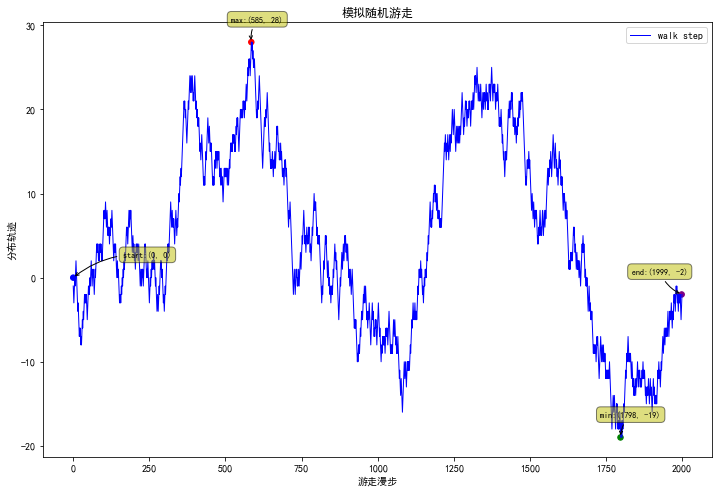

In [27]:
draw_random_walk()

### 正态随机漫步的特征

In [28]:
def simplot_random_walk():
    fig = plt.figure(figsize=(10,6))
    for _ in range(1000):
        plt.plot(np.arange(2000),random_walk(2000))
    plt.xlabel('游走步数')
    plt.ylabel('分布轨迹')
    plt.title(u'模拟随机漫步');

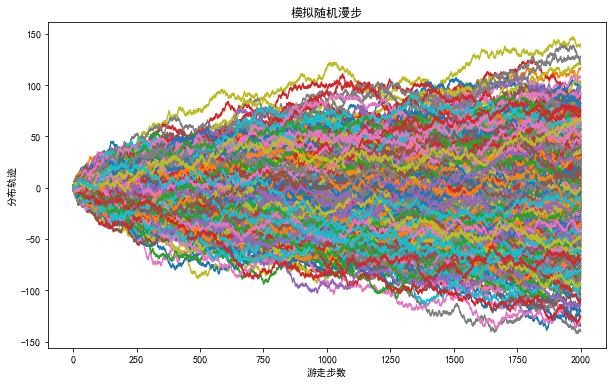

In [29]:
simplot_random_walk()

In [30]:
def sim_normal_distribution():
    fig = plt.figure(figsize=(10,6))
    end_path = [random_walk(2000)[-1] for _ in np.arange(0, 1000)]
    plt.hist(end_path, bins=50, density=True)
    plt.xlabel('游走步数')
    plt.ylabel('分布轨迹')
    plt.title(u'模拟随机漫步');

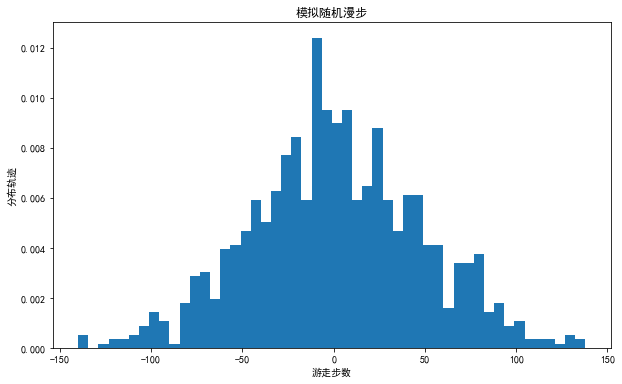

In [31]:
sim_normal_distribution()